## Семинар 9: "LSTM"

ФИО: Быстров Иван Дмитриевич

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
#from pytorch_forecasting.metrics import MAPE
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset, TensorDataset
from IPython.display import clear_output
import sys
%matplotlib inline

Этот семинар посвящен реализации RNN в pyTorch

## Задание 1

Напишите свою реализацию LSTM.

<img src="https://cdn-images-1.medium.com/max/1600/1*hl9UVtgIcQkDIGD8VFykdw.png" width="640">

In [4]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gate_size = 4 * self.hidden_size
        
        self.W_i = nn.Parameter(torch.Tensor(input_size, self.gate_size).zero_())
        
        self.W_h = nn.Parameter(torch.Tensor(hidden_size, self.gate_size).zero_())
        
        self.b = nn.Parameter(torch.Tensor(self.gate_size).zero_())
        
        
    def forward(self, inputs, hidden):
        # inputs: (seq_len, batch_size, input_size)
        # hidden: (batch_size, hidden_size) x 2. (no layers)
        
        h, c = hidden
        bs = h.size(0)
        
        seq_length = inputs.size(0)
        out = torch.autograd.Variable(torch.Tensor(seq_length, bs, self.hidden_size))
        
        for i, inp in enumerate(inputs):
            S = (torch.matmul(inp, self.W_i) + torch.matmul(h, self.W_h) + self.b)
            S = S.view(bs, 4, self.hidden_size)
            
            i_1 = torch.sigmoid(S[:,0,:])
            f_1 = torch.sigmoid(S[:,1,:])
            g_1 = torch.tanh(S[:,2,:])
            o_1 = torch.sigmoid(S[:,3,:])
            
            c = f_1 * c + i_1 * g_1
            h = o_1 * torch.tanh(c)
            out[i] = h
        return out, (h, c)

In [5]:
def train1(network, train_loader, test_loader, epochs=100, learning_rate=0.001):
    loss = nn.MSELoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            for X, y in train_loader:
                network.zero_grad()
                hidden = (torch.zeros(1, 1, network.hidden_size),
                          torch.zeros(1, 1, network.hidden_size))
                prediction, hidden = network(X, hidden)
                loss_batch = loss(prediction, y)
                optimizer.zero_grad()
                losses.append(loss_batch.item())
                loss_batch.backward()
                optimizer.step()
            train_loss_epochs.append(np.mean(losses))
            losses = [] 
            for X, y in test_loader:
                prediction, _ = network(X, hidden)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
            test_loss_epochs.append(np.mean(losses))
            clear_output(True)
            print('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}'.format(
                  epoch, train_loss_epochs[-1], test_loss_epochs[-1]))
            plt.figure(figsize=(6, 5))
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        pass

## Задание 2

Используя свою реализацию LSTM и torch.nn.LSTM (torch.nn.GRU) решить задачу предсказания временного ряда.
Попробуйте разные длины входной и выходной последовательности.
С помощью обученной сети получить из train-части временного ряда test-часть.

Данные о количестве пассажиров
https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

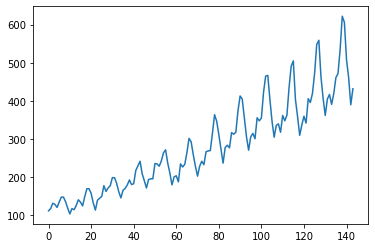

In [6]:
%matplotlib inline
dataset = pd.read_csv('international-airline-passengers.csv', usecols=[1], delimiter=";", engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

In [7]:
# подготовливаем данные

dataset = dataset.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [8]:
# разбиваем данные на train / test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))


96 48


In [9]:
# Целевая переменная - сдвинутая последовательность значений входов

def create_dataset(dataset, look_back=1, look_forward=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1-look_forward):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back : (i + look_back + look_forward), 0])

    return np.array(dataX), np.array(dataY)

In [10]:
# Пример подготовленных данных

look_back = 5
look_forward=1
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [11]:
train_dataset = TensorDataset(torch.from_numpy(trainX), torch.from_numpy(trainY))
train_dataloader =  DataLoader(train_dataset, batch_size=5)
test_dataset = TensorDataset(torch.from_numpy(testX), torch.from_numpy(testY))
test_dataloader =  DataLoader(test_dataset, batch_size=5)

Epoch 99... (Train/Test) NLL: 0.008/0.020


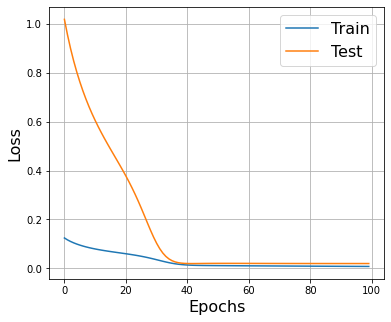

In [12]:
default_lstm =  nn.LSTM(hidden_size=look_forward, input_size=look_back)
train1(default_lstm, train_dataloader, test_dataloader)

Epoch 99... (Train/Test) NLL: 0.005/0.020


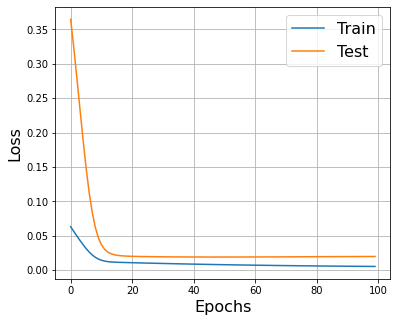

In [12]:
handmade_lstm = LSTM(hidden_size=look_forward, input_size=look_back)
train1(handmade_lstm, train_dataloader, test_dataloader)

In [13]:
def pred_plot(network, dataset, test_dataloader, train_size, hidden_size):
    hidden = (torch.zeros(1, 1, network.hidden_size),
              torch.ones(1, 1, network.hidden_size))
    predicted = []
    network.zero_grad()
    for X, y in test_dataloader:
        predy, hidden = network(X, hidden)
        for elem in predy.detach().flatten().tolist():
            predicted.append(elem)
    predicted = np.array(predicted)
    plt.figure(figsize=(6, 5))
    plt.plot(dataset[0:len(dataset),:], color = 'blue')
    temp = dataset.copy()
    temp[-len(predicted):] = predicted.reshape(-1,1)
    plt.plot(np.arange(len(dataset) - len(predicted), len(dataset)), temp[-len(predicted):], color = 'red')
    plt.grid()
    plt.show()
    return np.array(predicted)

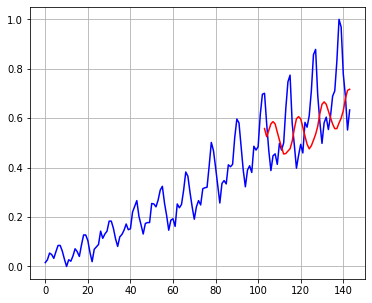

array([0.55809861, 0.52521741, 0.55055279, 0.5771842 , 0.58599985,
       0.57634312, 0.54338986, 0.51168633, 0.48114625, 0.45512709,
       0.45706782, 0.46699253, 0.47632545, 0.50701594, 0.5570609 ,
       0.59755474, 0.60644287, 0.5973835 , 0.56362575, 0.52735889,
       0.49491724, 0.47581923, 0.48866394, 0.51085848, 0.53467113,
       0.56695777, 0.61847675, 0.6562295 , 0.66602796, 0.65632838,
       0.62920713, 0.60226703, 0.57638025, 0.55770445, 0.55788583,
       0.58071464, 0.60004848, 0.6301071 , 0.67858571, 0.71261728,
       0.71709359])

In [14]:
pred_plot(handmade_lstm, dataset, test_dataloader, train_size, look_forward)

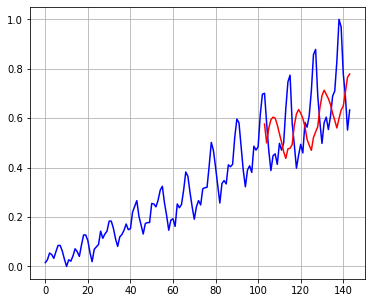

array([0.57635534, 0.49981534, 0.55968797, 0.5934996 , 0.60429651,
       0.60008168, 0.57288766, 0.5371654 , 0.50341749, 0.46389651,
       0.43736148, 0.47602019, 0.47831064, 0.49358439, 0.571868  ,
       0.61689919, 0.6350376 , 0.62065321, 0.59906089, 0.56503117,
       0.51371789, 0.49083737, 0.46995527, 0.52178657, 0.54445183,
       0.56533408, 0.64082539, 0.69080293, 0.71330112, 0.69621199,
       0.679263  , 0.6549446 , 0.61943507, 0.5910157 , 0.56049985,
       0.59848803, 0.63291705, 0.64943111, 0.70556825, 0.76580119,
       0.77877843])

In [15]:
pred_plot(default_lstm, dataset, test_dataloader, train_size, look_forward)

## Задание 3 

Поучаствуйте в соревновании https://www.kaggle.com/t/374fc477c4744b009a837153ce135cfb 

Для зачета задания нужно получить значение MAPE меньше 0.2

До 1 мая 2021 можно получить 3,2,1 дополнительных балла за 1, 2 и 3 место соответственно.


Опиционально: сравните классические подходы (ARIMA, gradient boosting trees и RNN)

In [16]:
#Доступа к соревнованию нет, модель надо будет переделать

In [17]:
def train2(network, train_loader, epochs=100, learning_rate=0.001):
    loss = nn.MSELoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            for X, y in train_loader:
                network.zero_grad()
                hidden = (torch.zeros(1, 1, network.hidden_size),
                          torch.zeros(1, 1, network.hidden_size))
                prediction = network(X, hidden)
                loss_batch = loss(prediction, y)
                optimizer.zero_grad()
                losses.append(loss_batch.item())
                loss_batch.backward()
                optimizer.step()
            train_loss_epochs.append(np.mean(losses))
            clear_output(True)
            print('\rEpoch {0}... (Train) NLL: {1:.3f}'.format(
                  epoch, train_loss_epochs[-1]))
                        #epoch, train_loss_epochs[-1], test_loss_epochs[-1]))
            plt.figure(figsize=(6, 5))
            plt.plot(train_loss_epochs, label='Train')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        pass

In [18]:
class NET(nn.Module):
  def __init__(self, inp_size, hid_size, out_size):
        super(NET, self).__init__()
        self.hidden_size = hid_size
        self.output_size = out_size
        self.lstm        = LSTM(inp_size,  self.hidden_size)
        self.linear      = nn.Sequential(nn.Linear(self.hidden_size, 128))
        self.conv_blocks = nn.Sequential(nn.Conv2d(1, 32, 3, 2),
                                         nn.ReLU(),
                                         nn.Conv2d(32, 64, 3, 2),
                                         nn.ReLU())
        self.last_linear = nn.Sequential(nn.Linear(192, self.output_size))
      
  def forward(self, X, hidden):
        output, _    = self.lstm(X, hidden)
        output    = output.view(X.shape[0], -1)
        output    = self.linear(output)
        output    = output.view(X.shape[0], 1, 8, 16)
        output    = self.conv_blocks(output)
        output    = output.view(X.shape[0], -1)
        output    = self.last_linear(output)
        return output

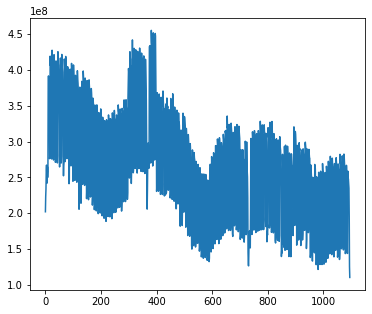

In [19]:
data = pd.read_csv('train.csv', usecols=[1])#, #usecols=[1], delimiter=",", engine='python', skipfooter=3)
plt.figure(figsize=(6, 5))
plt.plot(data)
plt.show()

In [20]:
lb = 65
lf = 1
scaler = MinMaxScaler(feature_range=(0, 1))
data_transformed = data.astype('float32')
data_transformed = scaler.fit_transform(data_transformed.values)
X_train, Y_train = create_dataset(data_transformed, lb, lf)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(Y_train))
train_dataloader = DataLoader(train_dataset, batch_size=5)

Epoch 99... (Train) NLL: 0.003


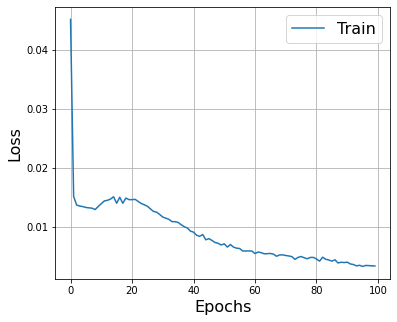

In [21]:
model = NET(lb, 120, lf)
train2(model, train_dataloader, epochs=100, learning_rate=0.001)

In [22]:
def comp_pred(network, hidden_size, data):
    result = []
    test = data[-hidden_size:]
    network.eval()
    for i in range(365):
        X_test = []
        X_test.append(test[i:i+hidden_size, 0])
        X_test = np.reshape(np.array(X_test), (np.array(X_test).shape[0], 1, np.array(X_test).shape[1]))
        X = torch.tensor(X_test)
        hidden = (torch.zeros(1, network.hidden_size),
                  torch.zeros(1, network.hidden_size))
        prediction = network(X, hidden).detach().numpy()
        result.append(np.mean(prediction))
        test = np.vstack((test, prediction))
    return result

In [23]:
result = comp_pred(model, lb, data_transformed)
final_res = []
for elem in result:
    final_res.append([elem])
res_inv = scaler.inverse_transform(final_res)
final_res = []
for elem in res_inv:
    final_res.append(elem[0])

In [24]:
df = pd.DataFrame()
df['date'] = pd.date_range("2019-01-01", periods=365, freq="D")
df['hits'] = final_res

In [25]:
df

,date,hits
0,2019-01-01,2.265651e+08
1,2019-01-02,2.449977e+08
2,2019-01-03,2.377775e+08
3,2019-01-04,2.265025e+08
4,2019-01-05,1.397642e+08
...,...,...
360,2019-12-27,2.490057e+08
361,2019-12-28,1.586481e+08
362,2019-12-29,1.522787e+08
363,2019-12-30,2.626113e+08


In [26]:
df.to_csv('ans.csv')

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: